# Conectar com Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd /content/gdrive/MyDrive/Colab/jai2021-jupyter-colab/4.Transformacao

!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab/jai2021-jupyter-colab/4.Transformacao
4.1.Integracao.ipynb  4.2.Transformacao.ipynb  4.3.Reducao.ipynb


In [2]:
# Importando os pacotes necessários
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [3]:
# Comandos auxiliares
from IPython.core.display import display, HTML
pd.set_option('display.max_columns', 10)
pd.options.mode.chained_assignment = None  # default='warn'

def display_side_by_side(dfs: list, captions: list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes(
            "style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# Transformação de Dados
---

Em geral, após um processo de <ins>**Integração de dados**</ins>, colunas com diferentes tipos de dados podem ser geradas. 

Na <ins>**Transformação de dados**</ins>, o principal objetivo é exatamente **transformar** esses dados de diferentes formatos em um formato suportado pelo processo de pesquisa, e.g., modelos e algoritmos. 

A <ins>**Transformação de dados**</ins> possui algumas etapas em comum com a <ins>**Limpeza de dados**</ins>, incluindo técnicas de remoção de ruído e discretização de dados. 

Portanto, nesta etapa, nós vamos focar nas técnicas que ainda não foram abordadas até aqui.

## Dados não padronizados

Dados coletados de diferentes fontes podem reunir dados **heterogêneos**, **não padronizados** e em **diferentes escalas** que muitas vezes necessitam um pré-processamento, i.e., uma etapa de escalonamento. 

O escalonamento de tais dados não é uma etapa obrigatória, mas uma boa prática! 

> **Mas... Por que precisamos dimensionar as variáveis em nosso conjunto de dados?** 🤔

> *Muitos algoritmos de Aprendizado de Máquina apresentam um melhor desempenho quando as variáveis numéricas de entrada são padronizadas.*

Isso inclui algoritmos que usam uma soma ponderada da entrada como, por exemplo, a regressão linhear e algoritmos que usam medidas de distância, como os algoritmos K-means e K-NN.

Existem algumas técnicas de escalonamento que **transformam** características para uma escala, magnitude ou intervalo. 

Para descrever e exemplicar cada uma delas, utilizaremos o conjunto de atributos numéricos que descrevem as músicas do Spotify, ou seja, a tabela `Tracks` do nosso conjunto de dados. 

In [4]:
# Lendo os dados
data = pd.read_table('../dataset/spotify_hits_dataset_complete.tsv', encoding='utf-8')
data.head(3)

song_id    song_name                   artist_id  \
0  2rRJrJEo19S2J82BDsQ3F7      Falling  ['7uaIm6Pw7xplS8Dy06V6pT']   
1  3BYIzNZ3t9lRQCACXSMLrT      Venetia  ['4O15NlyKLIASxsJ0PrXPfz']   
2  1g3J9W88hTG173ySZR6E9S  Tilidin Weg  ['1aS5tqEs9ci5P9KD9tZWa6']   

         artist_name  popularity  ...  liveness loudness  speechiness  \
0  ['Trevor Daniel']          77  ...    0.0887   -8.756       0.0364   
1   ['Lil Uzi Vert']          66  ...    0.1480   -4.139       0.1750   
2       ['Bonez MC']          13  ...    0.0838   -8.544       0.2330   

   valence    tempo  
0    0.236  127.087  
1    0.562  142.933  
2    0.171  109.090  

[3 rows x 24 columns]

In [5]:
# Selecionando apenas as variáveis numéricas
df = data.select_dtypes(include=['number'])
# print(df.columns.values) # imprime as colunas restantes

Depois de selecionar as variáveis numéricas da nossa tabela, ficamos com as seguintes informações:

* `popularity`: *score* de popularidade da track (o valor varia entre 0 e 100, sendo 100 o mais popular)
* `track_number`: número da track no álbum que ela pertence
* `num_artists`: número total de intérpretes da track
* `num_available_markets`: número total de países nos quais a track pode ser reproduzida
* `duration_ms`: duração da track em milissegundos
* [`key` - `tempo`]: características acústicas da track

Utilizando esses atributos, nós iremos explorar dois tipos de escalonamento: *Normalização* e *Padronização*.

### NORMALIZAÇÃO

A *Normalização* é uma técnica de escalonamento em que os valores são **deslocados** e **redimensionados** para que fiquem entre 0 e 1. Essa técnica também é conhecida como nomarlização *Min-Max* e é usada para **transformar** dados em uma <ins>escala semelhante</ins>.

A fórmula da *Normalização* é dada por:

$$X' = \frac{X - X_{min}}{X_{max} - X_{min}},$$

onde $X_{max}$ e $X_{min}$ são os valores máximo e mínimo do atributo, respectivamente.

**RESUMINDO**
* O valor mínimo da coluna será transformado em 0
* O valor máximo da coluna será transformado em 1
* Os valores que estiverem entre o valor mínimo e máximo, estarão entre o intervalo de 0 a 1

#### EXEMPLO
No exemplo a seguir, nós iremos normalizar todas as colunas numéricas da tabela `Tracks`.

Isto é, para cada atributo (i.e., coluna), nós aplicaremos a fórmula da *Normalização Min-Max*. 

Para isso, nós utilizaremos os métodos `min()` e `max()` do *pandas*:

In [6]:
df_norm = df.copy()  # cópia do DataFrame

# Para cada coluna de df_norm,
for coluna in df_norm.columns:
    
    # Normalização Min-Max
    X = df_norm[[coluna]]
    df_norm[[coluna]] = (X - X.min()) / (X.max() - X.min())

display_side_by_side([df.head(3), df_norm.head(3)], ['Original', 'Normalizado']) # imprime as 3 primeiras linhas

### PADRONIZAÇÃO

A *Padronização* é outra técnica de escalonamento em que os valores são **centralizados** em torno da média. Isso significa que a média de cada atributo se iguala a 0 e a distribuição resultante tem um desvio padrão igual a 1.

A fórmula da *Padronização* é dada por:

$$X' = \frac{X - \mu}{\sigma},$$

onde $\mu$ e $\sigma$ são a média e o desvio padrão dos valores do atributo, respectivamente.

#### EXEMPLO
No exemplo a seguir, nós iremos padronizar todas as colunas numéricas da tabela `Tracks`.

Isto é, para cada coluna, os valores serão subtraídos pela média e divididos pelo desvio padrão, aplicando a fórmula descrita anteriormente. Para isso, nós utilizaremos os métodos `mean()` e `std()` do *pandas*:

In [7]:
df_padron = df.copy()  # cópia do DataFrame

# Para cada coluna de df_padron,
for coluna in df_padron.columns:
    
    # Padronização
    X = df_padron[[coluna]]
    df_padron[[coluna]] = (X - X.mean()) / (X.std())

display_side_by_side([df.head(3), df_padron.head(3)], ['Original', 'Padronizado']) # imprime as 3 primeiras linhas

---
## Engenharia de características (Feature Engineering)

Além do escalonamento, outra forma de **transformar** os dados é através da **Engenharia de características**. Nesta técnica, características de um conjunto de dados podem ser criadas ou removidas para melhorar o desempenho de modelos de Aprendizado de Máquina. 

Muitas técnicas de <ins>**Transformação**</ins> e <ins>**Limpeza de dados**</ins> também podem ser consideradas **Engenharia de características**, incluindo métodos de escalonamento, discretização e redução de dimensionalidade. 

Portanto, a seguir, nós vamos discutir algumas técnicas que ainda não foram abordadas.

#### EXEMPLO

Para exemplificar, utilizaremos dessa vez as variáveis não-numéricas da tabela `Tracks`.

In [8]:
# Selecionando apenas variáveis não-numéricas
df = data.select_dtypes(exclude=['number'])
df = df.drop(columns=['song_id', 'song_name', 'artist_id', 'artist_name']) # removendo colunas desnecessárias
# print(df.columns.values) # imprime as colunas restantes

Depois de selecionar as variáveis, ficamos com os seguintes dados:

* `explicit`: *flag* indicando se a track contém conteúdo explícito
* `song_type`: se a track é do tipo *Solo* ou *Collaboration*
* `release_date`: data de lançamento da track

Utilizando esses atributos, nós iremos explorar duas formas de **Engenharia de características**: 

1. Converter variáveis categóricas em numéricas
2. Criar novos atributos a partir de variáveis de data

### CONVERTER DADOS CATEGÓRICOS

Variáveis categóricas são atributos que só podem assumir um número **limitado** e, geralmente, **fixo** de valores possíveis. 

Por exemplo, as músicas do Spotify contêm dados categóricos para informar se as músicas são explícitas ou não (`explicit`). 

In [9]:
df[['explicit']].head(3)

explicit
0     False
1      True
2     False

Ou seja, cada unidade de observação (i.e., música) é atribuída a um determinado grupo ou categoria nominal (i.e. [`False` ou `True`]). 

No entanto, muitos algoritmos e modelos de Aprendizado de Máquina têm dificuldades em processar dados categóricos, necessitando alguma forma de **transformar** tais atributos em variáveis numéricas. 

Uma das abordagens mais simples e comuns é converter variáveis categóricas em *dummies* ou indicadores, utilizando a função `get_dummies()` do *pandas*, conforme o exemplo a seguir. 

In [10]:
# Selecionando os atributos categóricos
df = data[['explicit', 'song_type']].astype('category')

# Convertendo em dummies
df_dummies = pd.get_dummies(df)

display_side_by_side([df.head(3), df_dummies.head(3)], ['Original', 'Transformado']) # imprime as 3 primeiras linhas

O método `get_dummies()` cria uma nova coluna contendo 0s e 1s para cada categoria possível do atributo, onde:

* `0`: indica que o dado não é daquela categoria
* `1`: indica que o dado é daquela categoria 

Como os dois atributos têm apenas duas categorias possíveis, o método criou duas colunas para cada atributo.


> Bom, agora que vimos como converter **dados categóricos** em dados **numéricos**, vamos ver como criar novos atributos a partir de variáveis de **data**! 😉

### VARIÁVEIS DE DATA

Datas e horários são fontes valiosas de informações que podem ser usadas em projetos de Ciência de Dados.

Por exemplo, em um modelo de predição de sucesso musical, pode ser útil considerar a data de lançamento das músicas. De fato, existem casos onde o período de lançamento influencia diretamente no sucesso musical.
**Exemplos:** músicas de Carnaval, músicas natalinas, músicas da Copa, etc.
 
No entanto, tecnicamente, as variáveis de data requerem alguma **Engenharia de características** para **transformá-las** em dados numéricos antes de serem usadas pelos algoritmos de Aprendizado de Máquina. 

#### EXEMPLO

Para exemplificar, utilizaremos a data de lançamento das músicas do Spotify (`release_date`) convertendo em formatos mais amigáveis, extraindo recursos e criando novas variáveis que podem ser usadas na análise de algum modelo. 

In [11]:
# Selecionando o id, nome e a data de lançamento das tracks
df = data[['song_id', 'song_name', 'release_date']]
df.head()

song_id                             song_name release_date
0  2rRJrJEo19S2J82BDsQ3F7                               Falling   2020-03-26
1  3BYIzNZ3t9lRQCACXSMLrT                               Venetia   2020-03-06
2  1g3J9W88hTG173ySZR6E9S                           Tilidin Weg   2020-07-30
3  75pQqzwgCjUOSSy5CpmAjy                            Pero Ya No   2020-02-28
4  7kDUspsoYfLkWnZR7qwHZl  my ex's best friend (with blackbear)   2020-09-25

O primeiro passo do processamento de datas é verificar se as variáveis estão em formato `datetime`.
Para isso, podemos utilizar o `dtypes` para verificar o tipo de cada coluna do nosso *DataFrame*: 

In [12]:
df.dtypes # verificando o tipo das colunas de df

song_id         object
song_name       object
release_date    object
dtype: object

Como podemos notar, o tipo da variável `release_date` é `object` e não `datetime`. Portanto, precisamos convertê-la antes de passar para a **Engenharia de características**. Para isso, usaremos o método `to_datetime()` do *pandas*:

In [13]:
df['release_date'] = pd.to_datetime(df['release_date']) # convertendo a data de lançamento em 'datetime'

In [14]:
df.dtypes # verificando o tipo das colunas de df

song_id                 object
song_name               object
release_date    datetime64[ns]
dtype: object

**Deu certo!** 😃

A biblioteca *pandas* disponibiliza diversas propriedades para variáveis `datetime`, incluindo:

* `year`: o ano da `datetime`
* `month`: o mês da `datetime`, onde `January=1` e `December=12`
* `day`: o dia da `datetime`

Então, depois de converter nossa variável para o tipo `datetime`, nós podemos quebrar a data de lançamento das músicas utilizando essas três propriedades:

In [15]:
# Extraindo propriedades básicas de uma variável datetime
df['day'] = df['release_date'].dt.day  # dia
df['month'] = df['release_date'].dt.month  # mês
df['year'] = df['release_date'].dt.year  # ano
df.head(3)

song_id    song_name release_date  day  month  year
0  2rRJrJEo19S2J82BDsQ3F7      Falling   2020-03-26   26      3  2020
1  3BYIzNZ3t9lRQCACXSMLrT      Venetia   2020-03-06    6      3  2020
2  1g3J9W88hTG173ySZR6E9S  Tilidin Weg   2020-07-30   30      7  2020

Além dessas propriedades básicas, existem outras informações que podemos extrair da nossa variável `datetime`.

Por exemplo, a semana do ano, o dia da semana e o trimestre:

In [16]:
# Extraindo propriedades extras de uma variável datetime
df['week'] = df['release_date'].dt.week  # semana do ano
df['dayofweek_index'] = df['release_date'].dt.dayofweek  # dia da semana (índice)
df['dayofweek_name'] = df['release_date'].dt.day_name() # dia da semana (nome)
df['quarter'] = df['release_date'].dt.quarter # trimestre
df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


song_id    song_name release_date  day  month  year  week  \
0  2rRJrJEo19S2J82BDsQ3F7      Falling   2020-03-26   26      3  2020    13   
1  3BYIzNZ3t9lRQCACXSMLrT      Venetia   2020-03-06    6      3  2020    10   
2  1g3J9W88hTG173ySZR6E9S  Tilidin Weg   2020-07-30   30      7  2020    31   

   dayofweek_index dayofweek_name  quarter  
0                3       Thursday        1  
1                4         Friday        1  
2                3       Thursday        3

---
## Dados desbalanceados

A última técnica de <ins>**Transformação de dados**</ins> que vamos analisar é a o **Balanceamento de dados**.  

Especificamente, nós podemos dizer que os dados estão desbalanceados quando existe uma **desproporção** de observações de cada classe do nosso modelo. Os impactos do desbalanceamento são implícitos, ou seja, não geram um erro imediato ao construir e executar um modelo. 

⚠️ Porém, os resultados podem ser **ilusórios**. 

Se o sinal da classe *majoritária* for **bem maior** do que o sinal da classe *minoritária*, o classificador pode gerar uma alta precisão geral, uma vez que o modelo provavelmente irá prever a maioria das amostras pertencentes à classe majoritária. O que não quer dizer que o modelo teve um bom desempenho no geral. 

Por exemplo, em um problema de duas classes com uma distribuição de classe de `90:10`, o desempenho ao classificar as classes *majoritárias* será **nove** vezes maior do que o desempenho em exemplos de classes *minoritárias*.

> **Achou confuso?** Vamos para um exemplo então! 😉

### EXEMPLO

Para exemplificar, suponha que você tenha um modelo de classificação onde você precisa prever se uma música será uma colaboração ou não, com base em suas características acústicas. 

Resumindo, você teria um modelo de classificação binária com duas classes: 

* `Collaboration`
* `Solo`

Para começar, então, vamos selecionar apenas as colunas referentes aos nossos preditores (i.e., as características acústicas das músicas) e a nossa variável *target*, i.e., `song_type`:

In [17]:
cols = [
    'duration_ms', 'key', 'mode', 'time_signature', 'acousticness',
    'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
    'speechiness', 'valence', 'tempo', 'song_type'
]

# Selecionando algumas colunas da tabela Tracks
data = pd.read_table('../dataset/spotify_hits_dataset_complete.tsv', encoding='utf-8', usecols=cols)
data.head(3)

song_type  duration_ms  key  mode  time_signature  ...  liveness  loudness  \
0      Solo       159381   10     0               4  ...    0.0887    -8.756   
1      Solo       188800    9     1               4  ...    0.1480    -4.139   
2      Solo       180950   10     0               4  ...    0.0838    -8.544   

   speechiness  valence    tempo  
0       0.0364    0.236  127.087  
1       0.1750    0.562  142.933  
2       0.2330    0.171  109.090  

[3 rows x 14 columns]

⚠️ Note que a variável *target* `song_type` está em formato não-numérico. Como vimos anteriormente, nós **precisaríamos** transformá-la em uma variável numérica caso esta variável fosse usada em algum algoritmo de Aprendizado de Máquina. 

No entanto, neste caso, tal variável corresponde ao que queremos prever (i.e., variável *target*). Portanto, não precisamos aplicar nenhum tratamento aqui.

Podemos, então, seguir para a verificação do balanceamento das classes (`Solo` e `Collaboration`). 
Para isso, usamos a função `value_counts()` que computa os valores únicos de cada categoria:

In [18]:
c = data['song_type'].value_counts() # quantidade de cada classe
p = data['song_type'].value_counts(normalize=True) # porcentagem de cada classe
pd.concat([c,round(p*100)], axis=1, keys=['counts', '%'])

counts     %
Solo              752  59.0
Collaboration     532  41.0

Podemos observar que cerca de 41% das observações (i.e., 532 músicas) são colaborações. 

Portanto, se tivéssemos que prever sempre músicas `Solo` obteríamos uma precisão de 59%.

A seguir, iremos testar esse cenário criando um modelo linear de regressão logística, usando o módulo `sklearn.linear_model` e a classe `LogisticRegression`. Para isso, nós seguimos os seguintes passos:

1. Separamos o conjunto de predidores (X) da nossa variável *target* (y);

In [19]:
# primeiro passo
y = data.song_type # variável target
X = data.drop('song_type', axis=1) # conjunto de preditores

2. Treinamos o modelo de regressão logística com os dois conjuntos X e y;

In [20]:
# segundo passo
logr = LogisticRegression().fit(X, y) # treinando o modelo de regressão logística

3. Realizamos a predição utilizando o mesmo conjunto de preditores X; e, por fim, 
4. Imprimimos os resultados.

In [21]:
# terceiro passo
pred_y_0 = logr.predict(X)
accuracy = round(accuracy_score(pred_y_0, y)*100)

# imprimindo os resultados
print(f'{accuracy}%') # acurácia do modelo
print(np.unique(pred_y_0)) # classes previstas pelo modelo

59%
['Solo']


Como podemos ver pelo resultado, nosso modelo apresentou uma precisão geral de 59%; ou seja, como consequência dos dados desbalanceados, o modelo prevê apenas uma classe. 

Em outras palavras, ele **ignora** a classe minoritária (i.e., `Collaborations`) em favor da classe majoritária (i.e., `Solo`). 

> **Então, como solucionar este problema?** 🤔

Uma técnica amplamente adotada para lidar com conjuntos de dados desbalanceados é a **Reamostragem**. 

#### REAMOSTRAGEM DE CLASSES

Esta técnica pode ser dividida em duas abordagens diferentes: 

* **Downsampling:** consiste em **remover** amostras da classe *majoritária* 
* **Oversampling:** consiste em **adicionar** mais exemplos da classe *minoritária*  

<br>
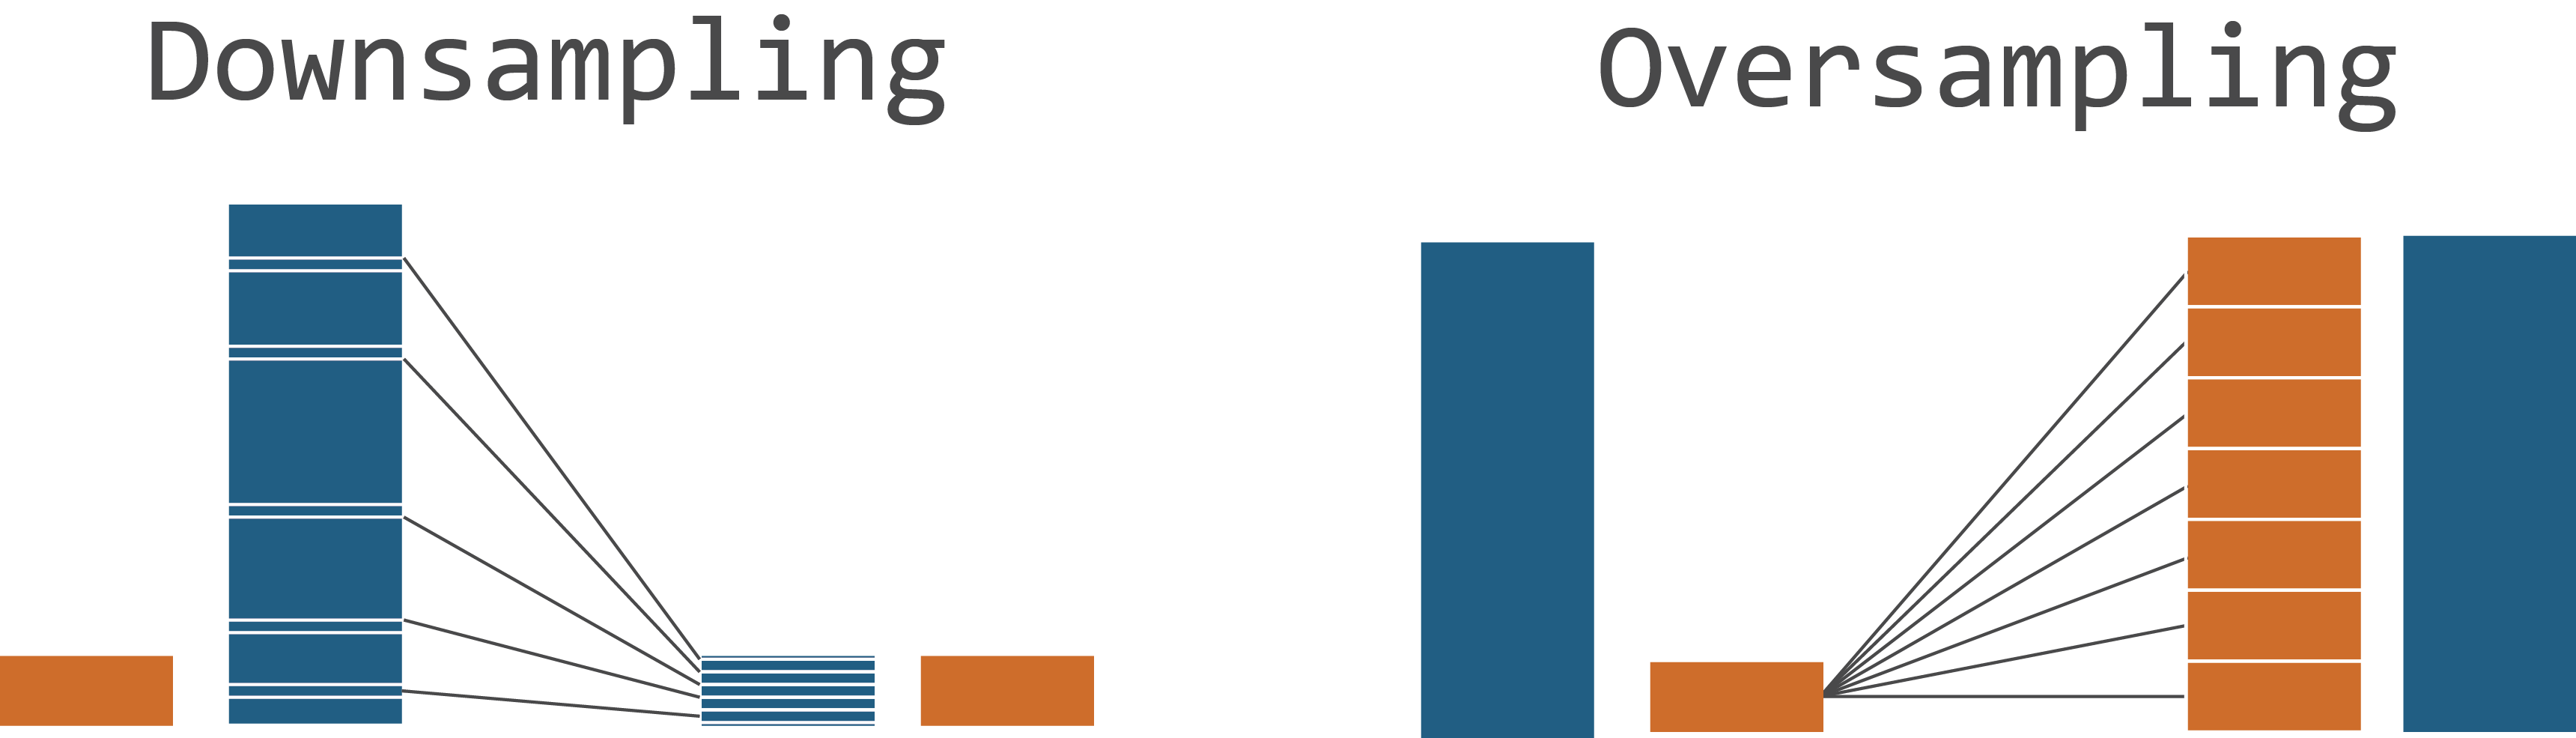

A seguir, vamos aplicar as duas técnicas no nosso exemplo de predição de colaborações.

---

**1. Downsampling** 

Começamos aplicando a técnica de *Downsampling*, que remove aleatoriamente observações da classe majoritária para evitar que seu sinal domine o algoritmo de aprendizagem. Para isso, seguimos alguns passos:

1. Separamos as observações de cada classe em diferentes *DataFrames*;

In [22]:
# primeiro passo
df_majority = data[data.song_type == 'Solo'] # classe majoritária
df_minority = data[data.song_type == 'Collaboration'] # classe minoritária

2. Realizamos uma amostragem da classe majoritária sem substituição para corresponder ao número total da classe minoritária;

In [23]:
# segundo passo
df_majority_downsampled = resample(
    df_majority, replace=False,  # amostra sem substituição
    n_samples=len(df_minority),  # para corresponder à classe minoritária
    random_state=123)  # garantindo reprodutibilidade

3. Concatenamos o *DataFrame* da classe minoritária com o *DataFrame* resultante;

In [24]:
# terceiro passo
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.song_type.value_counts()

Solo             532
Collaboration    532
Name: song_type, dtype: int64

In [25]:
print(df_downsampled.shape[0], data.shape[0]) # comparando o tamanho dos DataFrames

1064 1284


⚠️ Note que, apesar do novo *DataFrame* ter menos observações do que o original, a proporção das duas classes está **balanceada**. 

Agora, podemos treinar novamente o modelo de regressão logística! 

In [26]:
# primeiro passo
y = df_downsampled.song_type # variável target
X = df_downsampled.drop('song_type', axis=1) # conjunto de preditores

# segundo passo
logr = LogisticRegression().fit(X, y) # treinando o modelo de regressão logística

# terceiro passo
pred_y_1 = logr.predict(X)
accuracy = round(accuracy_score(pred_y_1, y)*100)

# imprimindo os resultados
print(f'{accuracy}%') # acurácia do modelo
print(np.unique(pred_y_1)) # classes previstas pelo modelo

49%
['Collaboration' 'Solo']


Obeserve que, após o balanceamento, o modelo consegue prever as duas classes e, apesar de apresentar uma menor precisão (49%), o modelo apresenta uma métrica de avaliação mais significativa. 

**2. Oversampling** 

Vamos, agora, aplicar a técnica de *Oversampling*, que replica aleatoriamente observações da classe minoritária. Para isso, seguimos alguns passos:

1. Separamos as observações de cada classe em diferentes *DataFrames*;

In [27]:
# primeiro passo
df_majority = data[data.song_type == 'Solo'] # classe majoritária
df_minority = data[data.song_type == 'Collaboration'] # classe minoritária

2. Realizamos a replicação da classe minoritária para corresponder ao número total da classe majoritária;

In [28]:
# segundo passo
df_minority_oversampled = resample(
    df_minority, # replicação aleatória
    n_samples=len(df_majority),  # para corresponder à classe majoritária
    random_state=123)  # garantindo reprodutibilidade

3. Concatenamos o *DataFrame* da classe majoritária com o *DataFrame* resultante.

In [29]:
# terceiro passo
df_oversampled = pd.concat([df_minority_oversampled, df_majority])
df_oversampled.song_type.value_counts()

Collaboration    752
Solo             752
Name: song_type, dtype: int64

In [30]:
print(df_oversampled.shape[0], data.shape[0]) # comparando o tamanho dos DataFrames

1504 1284


Observe que, desta vez, o novo *DataFrame* possui mais observações do que o original após a replicação das classes minoritárias, como esperado.

Agora, podemos treinar novamente o modelo de regressão logística!

In [31]:
# primeiro passo
y = df_oversampled.song_type # variável target
X = df_oversampled.drop('song_type', axis=1) # conjunto de preditores

# segundo passo
logr = LogisticRegression().fit(X, y) # treinando o modelo de regressão logística

# terceiro passo
pred_y_1 = logr.predict(X)
accuracy = round(accuracy_score(pred_y_1, y)*100)

# imprimindo os resultados
print(f'{accuracy}%') # acurácia do modelo
print(np.unique(pred_y_1)) # classes previstas pelo modelo

49%
['Collaboration' 'Solo']


Mais uma vez, após o balanceamento, o modelo conseguiu prever as duas classes apresentando uma métrica de precisão mais significativa. 

## Conclusão

Este notebook apresentou como fazer a transformação de dados de diferentes formatos a partir de diversas abordagens.

🔎 **Se interessou?** 

* Dê uma olhada na documentação da biblioteca *sklearn* para informações extras sobre transformação de dados:
[Dataset transformations](https://scikit-learn.org/stable/data_transforms.html)
* Para mais propriedades de variáveis `datetime`, veja a documentação do *pandas*: [DatetimeIndex](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html)

---

O próximo notebook ([4.3.Reducao.ipynb](https://drive.google.com/file/d/1vHtH8O5iQnsMLQggwwBiacGc6sbqSOsK/view?usp=sharing)) apresenta como aplicar técnicas de redução de dados para auxiliar a análise de dados com alta dimensionalidade.